In [3]:
import cv2
import numpy as np

def calculate_yellow_area(image_path):
    # Read the image
    img = cv2.imread(image_path)
    
    # Convert to HSV color space (better for color detection)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define yellow color range in HSV
    # You might need to adjust these values depending on your specific yellow
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([40, 255, 255])
    
    # Create a mask for yellow pixels
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    # Count non-zero pixels (yellow pixels)
    yellow_pixels = cv2.countNonZero(yellow_mask)
    
    return yellow_pixels

def compare_areas(image1_path, image2_path, tolerance=0.01):
    # Calculate areas
    area1 = calculate_yellow_area(image1_path)
    area2 = calculate_yellow_area(image2_path)

    # Calculate difference percentage
    difference = abs(area1 - area2) / max(area1, area2)

    # Compare with tolerance
    are_equal = difference <= tolerance

    return {
        'are_equal': are_equal,
        'area1': area1,
        'area2': area2,
        'difference_percentage': difference * 100
    }

# Usage example
image1_path = "images/two_shapes2/train/circle/circle_11000_209_314_89_v2.png"
image2_path = "images/two_shapes2/train/star/star_11000_172_287_109_v2.png"

result = compare_areas(image1_path, image2_path)
print(f"Areas are {'equal' if result['are_equal'] else 'different'}")
print(f"Area 1: {result['area1']} pixels")
print(f"Area 2: {result['area2']} pixels")
print(f"Difference: {result['difference_percentage']:.2f}%")

Areas are equal
Area 1: 11089 pixels
Area 2: 10998 pixels
Difference: 0.82%


In [33]:
import cv2
import numpy as np
import os
import pandas as pd
from collections import defaultdict
import re


def calculate_yellow_area(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([40, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    return cv2.countNonZero(yellow_mask)


def extract_surface_value(filename):
    # Extract the number between underscores
    match = re.search(r"_(\d+)_", filename)
    if match:
        return int(match.group(1))
    return None


def analyze_images(circle_dir, star_dir):
    # Dictionaries to store areas for each target surface
    circle_areas = defaultdict(list)
    star_areas = defaultdict(list)

    # Process circle images
    print("Processing circle images...")
    for filename in os.listdir(circle_dir):
        if filename.endswith(".png"):
            try:
                surface_value = extract_surface_value(filename)
                if surface_value:
                    area = calculate_yellow_area(os.path.join(circle_dir, filename))
                    circle_areas[surface_value].append(area)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

    # Process star images
    print("Processing star images...")
    for filename in os.listdir(star_dir):
        if filename.endswith(".png"):
            try:
                surface_value = extract_surface_value(filename)
                if surface_value:
                    area = calculate_yellow_area(os.path.join(star_dir, filename))
                    star_areas[surface_value].append(area)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

    # Create summary statistics
    results = []
    all_surfaces = sorted(set(circle_areas.keys()) | set(star_areas.keys()))

    for surface in all_surfaces:
        circle_stats = {
            "mean": np.mean(circle_areas[surface]) if circle_areas[surface] else np.nan,
            "std": np.std(circle_areas[surface]) if circle_areas[surface] else np.nan,
        }
        star_stats = {
            "mean": np.mean(star_areas[surface]) if star_areas[surface] else np.nan,
            "std": np.std(star_areas[surface]) if star_areas[surface] else np.nan,
        }

        results.append(
            {
                "target_surface": surface,
                "circle_mean": circle_stats["mean"],
                "circle_std": circle_stats["std"],
                "star_mean": star_stats["mean"],
                "star_std": star_stats["std"],
                "n_circle_images": len(circle_areas[surface]),
                "n_star_images": len(star_areas[surface]),
            }
        )

    # Create DataFrame
    df = pd.DataFrame(results)
    df = df.sort_values("target_surface")

    return df


# Usage
circle_dir = "images/two_shapes2/train/circle" 
star_dir = "images/two_shapes2/train/star"

try:
    results_df = analyze_images(circle_dir, star_dir)
    # Save to CSV
    results_df.to_csv("shape_analysis_results.csv", index=False)
    print("\nResults have been saved to 'shape_analysis_results.csv'")

except Exception as e:
    print(f"An error occurred: {str(e)}")

Processing circle images...
Processing star images...

Results have been saved to 'shape_analysis_results.csv'


/tmp/ipykernel_15633/3668463154.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results_df["circle_ratio"], results_df["star_ratio"]], labels=["Circle", "Star"])


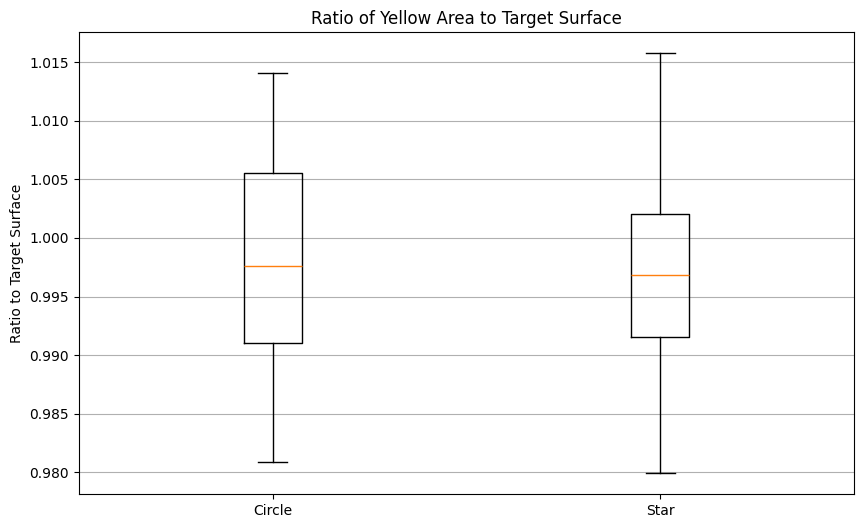

In [34]:
# compute the ratios of circle and star to target areas
results_df["circle_ratio"] = results_df["circle_mean"] / results_df["target_surface"]
results_df["star_ratio"] = results_df["star_mean"] / results_df["target_surface"]
# draw a boxplot of the ratios
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot([results_df["circle_ratio"], results_df["star_ratio"]], labels=["Circle", "Star"])
plt.ylabel("Ratio to Target Surface")   
plt.title("Ratio of Yellow Area to Target Surface")
plt.grid(axis="y")
plt.show()

In [9]:
results_df

,target_surface,circle_mean,circle_std,star_mean,star_std,n_circle_images,n_star_images,circle_ratio,star_ratio
0,10000,10004.925,1.058005,9294.0,0.0,200,200,1.000493,0.929400
1,10100,10005.000,0.000000,9615.0,0.0,200,200,0.990594,0.951980
2,10200,10005.000,0.000000,9615.0,0.0,200,200,0.980882,0.942647
3,10300,10365.000,0.000000,9789.0,0.0,200,200,1.006311,0.950388
4,10400,10365.000,0.000000,9789.0,0.0,200,200,0.996635,0.941250
...,...,...,...,...,...,...,...,...,...
95,19500,19341.000,0.000000,18088.0,0.0,200,200,0.991846,0.927590
96,19600,19340.830,1.691479,18493.0,0.0,200,200,0.986777,0.943520
97,19700,19836.915,1.199073,18493.0,0.0,200,200,1.006950,0.938731
98,19800,19836.830,1.691479,18493.0,0.0,200,200,1.001860,0.933990


In [20]:
import numpy as np


def radius_from_area(area: float) -> float:
    """
    Calculate the outer radius of a pentagram given its area.

    Args:
        area: The desired area of the pentagram

    Returns:
        The outer radius needed to create a pentagram with the given area
    """
    # Calculate the geometric constant used in area formula
    inner_to_outer_ratio = np.sin(np.pi / 10) / np.sin(7 * np.pi / 10)
    k = (5 / 2) * np.sin(2 * np.pi / 5) * (1 + inner_to_outer_ratio**2)

    # Return radius
    return np.sqrt(area / k)


def verify_area(radius: float) -> float:
    """
    Verify the calculation by computing the area from the radius.

    Args:
        radius: The outer radius of the pentagram

    Returns:
        The actual area of the pentagram
    """
    inner_radius = radius * np.sin(np.pi / 10) / np.sin(7 * np.pi / 10)
    area = (5 / 2) * np.sin(2 * np.pi / 5) * (radius**2 + inner_radius**2)
    return area


# Example usage
if __name__ == "__main__":
    target_area = 100
    radius = radius_from_area(target_area)
    actual_area = verify_area(radius)

    print(f"Target area: {target_area}")
    print(f"Calculated radius: {radius:.4f}")
    print(f"Verification - actual area: {actual_area:.4f}")

Target area: 100
Calculated radius: 6.0583
Verification - actual area: 100.0000
